Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

1. LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
2. SEX: пол клиента (1 = мужской, 2 = женский )
3. EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
4. MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
5. AGE: возраст в годах
6. PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
7. BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
8. PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
9. default - индикатор невозврата денежных средств

## Задание

## 1 
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [2]:
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import statsmodels.stats.weightstats as ssw
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def fold_change(c, t):
    if t > c:
        print("результаты практически значимы", t / c)
    else:
        return print("результаты практически не значимы", -c / t)

In [4]:
data = pd.read_csv("credit_card_default_analysis.csv")
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
yes = data[data['default'] == 1].drop('default', axis = 1)
no = data[data['default'] == 0].drop('default', axis = 1)

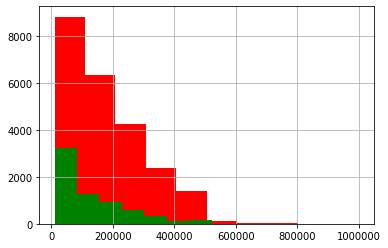

In [6]:
no.LIMIT_BAL.hist(color = 'r', label='default')
yes.LIMIT_BAL.hist(color = 'g', label='not_default')

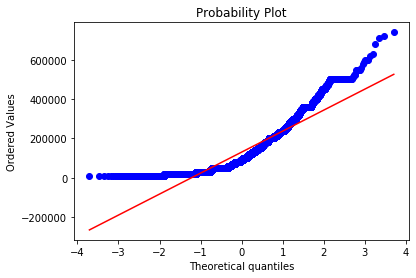

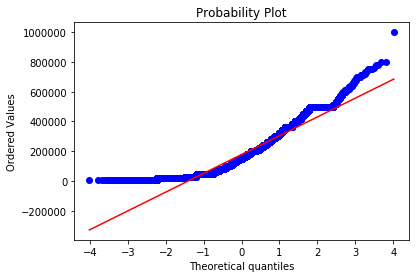

In [7]:
scipy.stats.probplot(yes.LIMIT_BAL, dist = 'norm', plot=pylab)
show()
scipy.stats.probplot(no.LIMIT_BAL, dist = 'norm', plot=pylab)
show()

Видим, что распределения не похожи на нормальные, но проверим это численно методом Шапира

H_o: Распределение нормальное 

H_1: Распределение не нормальное

In [8]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % scipy.stats.shapiro(yes.LIMIT_BAL))
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % scipy.stats.shapiro(no.LIMIT_BAL))

Shapiro-Wilk normality test, W-statistic: 0.854983, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.919726, p-value: 0.000000


Мы уверенно отвергаем H_0, а следовательно, лучше пользоваться непараметрическими методами, так что воспользуемся bootstrap

In [9]:
def get_bootstrap_samples(data, n_samples): #n_samples - кол-во подвыборок 
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples #n_samples подвыборок

def stat_intervals(stat, alpha): #высчитывает доверительные интервалы
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [10]:
print(np.median(yes.LIMIT_BAL.values), np.median(no.LIMIT_BAL.values)) # точечные оценки медиан

90000.0 150000.0


In [11]:
yes_median = list(map(np.median, get_bootstrap_samples(yes.LIMIT_BAL.values, 1000)))
no_median  = list(map(np.median, get_bootstrap_samples(no.LIMIT_BAL.values, 1000)))

delta_median_scores = list(map(lambda x: x[1] - x[0], zip(yes_median, no_median)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [60000. 70000.]


a) в интервале нет нуля, так что медианы не равны

Для ответа на пункт b, нам подойдет критерий mannwhitneyu

𝐻0:𝐹𝑋1(𝑥)=𝐹𝑋2(𝑥)  (среднее в выборках равно)

𝐻1:𝐹𝑋1(𝑥)=𝐹𝑋2(𝑥+Δ),Δ≠0 (среднее выборках отличается)

In [12]:
scipy.stats.mannwhitneyu(yes.LIMIT_BAL.values, no.LIMIT_BAL.values)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

In [13]:
fold_change(np.median(yes.LIMIT_BAL.values), np.median(no.LIMIT_BAL.values))

результаты практически значимы 1.6666666666666667


Уверено отвергаем 𝐻0, Мы узнали что выборки у нас различаются 

## 2
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [14]:
yes['SEX'] = yes['SEX'].apply(lambda x : 0 if x == 2 else 1) #замена на бинарные хначения
no['SEX'] = no['SEX'].apply(lambda x : 0 if x == 2 else 1)

Распределение SEX у нас бинарное

𝐻0:гендерный состав группы людей вернувших и не вернувших кредит одинаковый

𝐻1: отличается

Посмотрим соотношения м и ж

In [15]:
print('yes m: %d w: %d  no m: %d w: %d' % ((yes.SEX == 1).sum() , (yes.SEX == 0).sum(), (no.SEX == 1).sum() , (no.SEX == 0).sum()))

yes m: 2873 w: 3763  no m: 9015 w: 14349


Для удобства визуализируем это

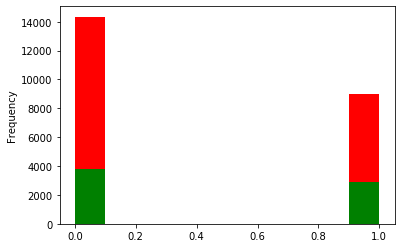

In [16]:
no['SEX'].plot.hist(color = 'r', label='default')
yes['SEX'].plot.hist(color = 'g', label='no_default')

Данные у нас бинарные и независимые, все условия соблюдены

In [17]:
cm = ssw.CompareMeans(ssw.DescrStatsW(yes.SEX.values), ssw.DescrStatsW(no.SEX.values)) # не уверен что CompareMeans подойдет для бинарных, так что на это решил не останавливаться
cm.tconfint_diff() 

(0.033766013413404336, 0.06041699731112106)

In [18]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):# доверительные интервалы (Д-И)
    z = scipy.stats.norm.ppf(1 - alpha / 2.) # расчитываем z статистику 
    
#     формулы выше
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2): #расчет z статистики
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)

    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'): # для расчета pvalue, z_stat - статистика, которую будем оценивать, alternative - вид альтернативы
    if alternative not in ('two-sided', 'less', 'greater'):# считаем уровень значимости
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [19]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(yes.SEX.values, no.SEX.values))

95% confidence interval for a difference between proportions: [0.033635, 0.060548]


In [20]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(yes.SEX.values, no.SEX.values)) )

p-value: 0.000000


In [21]:
z_stat = proportions_diff_z_stat_ind(yes.SEX, no.SEX)
print('z_stat :',z_stat)

z_stat : 6.921375088562897


p < 0.05, мы отвергаем H_o

CompareMeans упрощает жизнь

## 3
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

Для каждого типа образования 

H0 - нет разницы между долей отдавших и не отдавших кредит для этого уровня образования  (они не зависимы)

H1 - есть разница между долей отдавших и не отдавших кредит для этого уровня образования

In [36]:
cross = pd.crosstab(data.default, data.EDUCATION)
cross

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


Условия применимости критерия хи-квадрат:
$$n > 40$$ 
$$\frac{n_{i+}\cdot n{+j}}{n} < 5$$
n - кол-во объектов, $n_{i+}$ - сумма по i-й строке в таблице сопряженности, $n_{+j}$ - сумма по j-му столбцу в таблице сопряженности

In [48]:
cr = np.array(cross)
if cr.sum() > 40:
    print("Первое условие выполняется")
else:
    print("Первое условие не выполняется")
matrix_col_sum = cr.sum(axis=0)
matrix_row_sum = cr.sum(axis=1)
matrix_crit = np.array([matrix_row_sum[0] * matrix_col_sum, matrix_row_sum[1] * matrix_col_sum]) * (1.0 / cr.sum())
if (matrix_crit < 5).sum() < int(cr.shape[0] * cr.shape[1] * 0.2):
    print("Второе условие выполняется")
else:
    print("Второе условие не выполняется")

Первое условие выполняется
Второе условие выполняется


In [49]:
stat, p, _, exp = scipy.stats.chi2_contingency(cross)
print("Коэффициент V-Крамера составляет", round((stat / (cr.sum() * (min(cr.shape) - 1)))**0.5, 3))
print("pval=", p)

Коэффициент V-Крамера составляет 0.074
pval= 1.2332626245415605e-32


p < 0.05, отвергаем нулевую гипозету, Образование влияет на возвращаемость кредитов.

In [38]:
cros2 = (cross - exp) / exp
cros2

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,0.284027,0.037047,-0.020735,-0.039004,0.210952,0.201482,0.082611
1,-1.000000,-0.130436,0.073004,0.137324,-0.742719,-0.709377,-0.290856


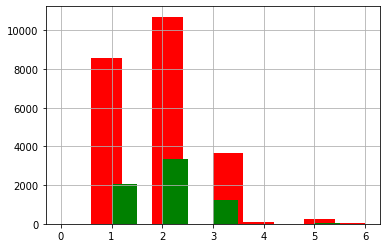

In [39]:
no.EDUCATION.hist(color = 'r' ,label='default')
yes.EDUCATION.hist(color = 'g',label='no_default')
plt.show()
#график соотношения EDUCATION и default

Наличие бакалавра образования является наилучшим индикатором того, что человек отдаст дол и так же не отдаст, как то бессмысленно получается, скорее всего людей с этим образованием большего всего просто

## 4
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

Для каждого типа образования 

H0 - семейное положение и погашение кридита не связаны

H1 - связаны

In [26]:
cross = pd.crosstab(data.default, data.MARRIAGE)
cross

MARRIAGE,0,1,2,3
default,,,,
0,49,10453,12623,239
1,5,3206,3341,84


<BarContainer object of 4 artists>

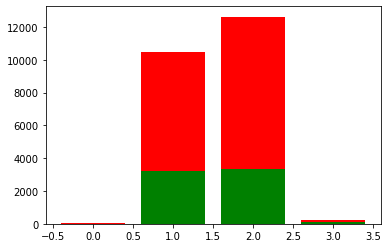

In [54]:
pylab.bar([0,1,2,3], cross.iloc[0], color = 'r', label = 'default')
pylab.bar([0,1,2,3], cross.iloc[1], color = 'g', label = 'no_default')
#график соотношения MARRIAGE и default

In [50]:
matrix = np.array(cross)
if matrix.sum() > 40:
    print("Первое условие выполняется")
else:
    print("Первое условие не выполняется")
matrix_col_sum = matrix.sum(axis=0)
matrix_row_sum = matrix.sum(axis=1)
matrix_crit = np.array([matrix_row_sum[0] * matrix_col_sum, matrix_row_sum[1] * matrix_col_sum]) * (1.0 / matrix.sum())
if (matrix_crit < 5).sum() < int(matrix.shape[0] * matrix.shape[1] * 0.2):
    print("Второе условие выполняется")
else:
    print("Второе условие не выполняется")

Первое условие выполняется
Второе условие выполняется


In [69]:
matrix_expected

array([[1.0903200e+01, 8.2435980e+03, 1.0926564e+04, 3.8293596e+03,
        9.5792400e+01, 2.1806400e+02, 3.9718800e+01],
       [3.0968000e+00, 2.3414020e+03, 3.1034360e+03, 1.0876404e+03,
        2.7207600e+01, 6.1936000e+01, 1.1281200e+01]])

In [51]:
stat, pval, a, matrix_expected = scipy.stats.chi2_contingency(cross)
print("Коэффициент V-Крамера составляет", round((stat / (matrix.sum() * (min(matrix.shape) - 1)))**0.5, 3))
print("pval=", p)

Коэффициент V-Крамера составляет 0.074
pval= 1.2332626245415605e-32


p меньше 0.05, отвергаем нулевую гипозету, брак влияет на возвращаемость кредитов

## 5
Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

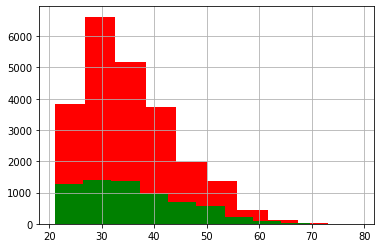

In [40]:
no.AGE.hist(color = 'r', label='default')
yes.AGE.hist(color = 'g', label='not_default')

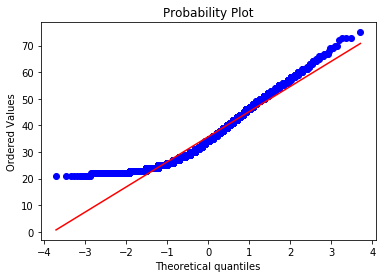

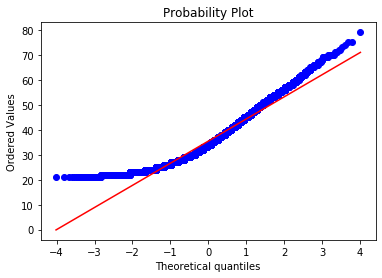

In [345]:
scipy.stats.probplot(yes.AGE, dist = 'norm', plot=pylab)
show()
scipy.stats.probplot(no.AGE, dist = 'norm', plot=pylab)
show()

Видим, что распределения не похожи на нормальные, но проверим это численно методом Шапира

H_o: Распределение нормальное

H_1: Распределение не нормальное

In [346]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % scipy.stats.shapiro(yes.AGE))
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % scipy.stats.shapiro(no.AGE))

Shapiro-Wilk normality test, W-statistic: 0.950164, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.949614, p-value: 0.000000


Мы уверенно отвергаем H_0 на уровне значимости 0.05, а следовательно, лучше пользоваться непараметрическими методами, так что воспользуемся bootstrap

In [347]:
yes_median = list(map(np.median, get_bootstrap_samples(yes.AGE.values, 1000)))
no_median  = list(map(np.median, get_bootstrap_samples(no.AGE.values, 1000)))

delta_median_scores = list(map(lambda x: x[1] - x[0], zip(yes_median, no_median)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [-1.  0.]


a) в интервале есть нуль, так что медианы равны

Для ответа на пункт b, нам подойдет критерий mannwhitneyu

𝐻0:𝐹𝑋1(𝑥)=𝐹𝑋2(𝑥) (среднее в выборках равно)

𝐻1:𝐹𝑋1(𝑥)=𝐹𝑋2(𝑥+Δ),Δ≠0 (среднее выборках отличается)

In [351]:
scipy.stats.mannwhitneyu(yes.AGE.values, no.AGE.values)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

не можем отвергнуть 𝐻0 на уровне значимости 0.05

In [85]:
fold_change(np.median(yes.AGE.values), np.median(no.AGE.values))

результаты не значимы -1.0


Результаты говорят о том, что возраст не особо важен

## Важно
1. Выполнение каждого пункта задания должно начинаться с графика с данными, которые вы собираетесь анализировать. Еще лучше, если вы разложите графики анализируемого фактора по переменной (default), на которую хотите изучить влияние этого фактора, и проинтерпретируете отличия в полученных распределениях.
2. При использовании статистических критериев необходимо убедиться в том, что условия их применимости выполняются. Например, если вы видите, что данные бинарные, то не нужно применять критерий Стьюдента.
3. При каждом использовании любого критерия необходимо указать, какая проверяется гипотеза, против какой альтернативы, чему равен достигаемый уровень значимости, принимается или отвергается нулевая гипотеза на уровне значимости 0.05. Если задача позволяет, нужно оценить размер эффекта и предположить, имеет ли этот результат практическую значимость.
4. Выполненное задание необходимо представить в ipython-ноутбука.